In [2]:
import torch
import torch.nn as nn

x = torch.randn(2, 32, 32, 96)  # (N, H, W, C)
ln = nn.LayerNorm(normalized_shape=96)
out = ln(x)

print(out.shape)

NameError: name '_C' is not defined

In [ ]:
from inception import Inception, InceptionBlock
import torch.nn as nn

class Flatten(nn.Module):
	def __init__(self, out_features):
		super(Flatten, self).__init__()
		self.output_dim = out_features

	def forward(self, x):
		return x.view(-1, self.output_dim)
    
class Reshape(nn.Module):
	def __init__(self, out_shape):
		super(Reshape, self).__init__()
		self.out_shape = out_shape

	def forward(self, x):
		return x.view(-1, *self.out_shape)
	
InceptionTime = nn.Sequential(
                Reshape(out_shape=(1,160)),
                InceptionBlock(
                    in_channels=1, 
                    n_filters=32, 
                    kernel_sizes=[5, 11, 23],
                    bottleneck_channels=32,
                    use_residual=True,
                    activation=nn.ReLU()
                ),
                InceptionBlock(
                    in_channels=32*4, 
                    n_filters=32, 
                    kernel_sizes=[5, 11, 23],
                    bottleneck_channels=32,
                    use_residual=True,
                    activation=nn.ReLU()
                ),
                nn.AdaptiveAvgPool1d(output_size=1),
                Flatten(out_features=32*4*1),
                nn.Linear(in_features=4*32*1, out_features=3)
    )

In [2]:
train_dataset[2][0].shape

torch.Size([30, 1, 75, 75])

c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\matplotlib\cbook\__init__.py:719: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  x = np.array(x, subok=True, copy=copy)


TypeError: Image data of dtype <U69 cannot be converted to float

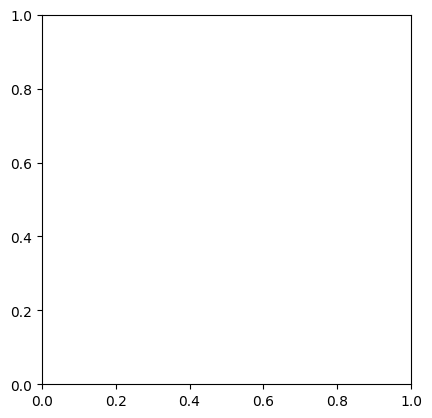

In [3]:
import matplotlib.pyplot as plt
from datatset import DROZY_FACE_Dataset

train_dataset = DROZY_FACE_Dataset(split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy/test")
mean_face = train_dataset[2]
plt.imshow(mean_face, cmap='gray')
plt.title("정규화 평균 얼굴 (0~1 스케일)")
plt.axis('off')
plt.show()

In [1]:
import matplotlib.pyplot as plt
import albumentations as A
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
from tqdm import tqdm
from datatset import DROZY_FACE_Dataset
import scipy.ndimage
import torchvision
import albumentations as A

# ============================
# 1. 시퀀스 단위 동일 증강
# ============================
import random
import time

train_transform = transforms.Compose([
    transforms.ToTensor()
])
train_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/train",
)
test_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/test",
    # test에는 증강 미적용
)

transform_video_seg = A.Compose([
    A.HorizontalFlip(p=0.8),
    A.RandomBrightnessContrast(p=0.8),
    A.RandomGamma(p=0.8),
    A.RandomRotate90(p=0.8),
    A.RandomScale(p=0.8),
])
# 첫 번째 샘플의 모든 프레임 시각화
img_tensor_seq = train_dataset[0][0]  # (T, H, W) 또는 (C, H, W) 또는 (T, C, H, W) 형태일 수 있음

import numpy as np

# img_tensor_seq가 torch.Tensor라면 numpy array의 list로 변환 필요
if isinstance(img_tensor_seq, torch.Tensor):
    # (T, H, W) 또는 (C, H, W) 또는 (T, C, H, W) 형태일 수 있음
    # (T, H, W) 또는 (T, C, H, W)만 처리한다고 가정
    if img_tensor_seq.ndim == 3:
        # (T, H, W) 또는 (C, H, W)
        if img_tensor_seq.shape[0] <= 4:  # (C, H, W)일 가능성
            # (C, H, W)라면 albumentations에 바로 넘길 수 없음
            # (T, H, W)로 가정
            img_list = [img_tensor_seq[i].cpu().numpy() for i in range(img_tensor_seq.shape[0])]
        else:
            # (T, H, W)
            img_list = [img_tensor_seq[i].cpu().numpy() for i in range(img_tensor_seq.shape[0])]
    elif img_tensor_seq.ndim == 4:
        # (T, C, H, W)
        img_list = [np.transpose(img_tensor_seq[i].cpu().numpy(), (1, 2, 0)) for i in range(img_tensor_seq.shape[0])]
    else:
        raise ValueError("지원하지 않는 텐서 shape입니다: {}".format(img_tensor_seq.shape))
else:
    img_list = img_tensor_seq

augmented = transform_video_seg(images=img_list, masks=img_list)
print(img_list[0].shape)

import matplotlib.pyplot as plt

# augmented["images"]는 증강된 프레임들의 리스트임
fig, axes = plt.subplots(1, len(augmented["images"]), figsize=(3 * len(augmented["images"]), 3))
if len(augmented["images"]) == 1:
    axes = [axes]
for i, img in enumerate(augmented["images"]):
    ax = axes[i]
    # img가 (H, W) 또는 (H, W, C) 형태일 수 있음
    if img.ndim == 2:
        ax.imshow(img, cmap='gray')
    else:
        # (H, W, C)일 경우
        ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'프레임 {i}')
plt.tight_layout()
plt.show()


c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


<class 'numpy.ndarray'>


TypeError: 'NoneType' object is not callable

In [3]:
import gc
import torch

gc.collect()


0

In [17]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
from tqdm import tqdm
from datatset import DROZY_FACE_Dataset
import scipy.ndimage
import torchvision
import albumentations as A

# ============================
# 1. 시퀀스 단위 동일 증강
# ============================
import random
import time

# albumentations의 Normalize를 추가하여 데이터 정규화 적용
transform_video_seg = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.5),
    # A.GaussNoise(p=0.3),
    # A.RandomBrightnessContrast(p=0.5, brightness_limit=0.2, contrast_limit=0.2),
    A.Normalize(mean=(0.5,), std=(0.5,)),  # 1채널 흑백 기준 정규화
])

train_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/train",
    transform=transform_video_seg
)
test_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/test",
    transform=A.Compose([A.Normalize(mean=(0.5,), std=(0.5,))])  # test도 정규화만 적용
)

# num_workers=0으로 변경 (메모리/환경에 따라 0 또는 2 추천)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

# ============================
# 2. EfficientNetB0 백본 + Self-Attention
# ============================
import torchvision.models as models

# 구조 단순화 및 Dropout/정규화/활성화 함수 개선
class CNN2D1D(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()
        # 2D CNN 백본: 각 프레임별 특징 추출
        self.cnn2d = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.GELU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.GELU(),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.GELU(),
        )
        self.cnn2d_out_dim = 256  # 마지막 채널 수

        # 1D CNN: 시퀀스(프레임) 간 특징 추출
        self.cnn1d = nn.Sequential(
            nn.Conv1d(self.cnn2d_out_dim, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
            nn.Conv1d(128, 128, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm1d(128),
            nn.GELU(),
        )
        self.cnn1d_out_dim = 128

        # 전역 평균 풀링 (시퀀스 차원)
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.cnn1d_out_dim, 256),
            nn.BatchNorm1d(256),
            nn.GELU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)
        elif isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.BatchNorm1d):
            nn.init.ones_(m.weight)
            nn.init.zeros_(m.bias)

    def forward(self, x):
        # x: (B, T, H, W) 또는 (B, 1, T, H, W)
        if x.ndim == 4:
            # (B, T, H, W) -> (B, 1, T, H, W)
            x = x.unsqueeze(1)
        if x.shape[1] == 1:
            x = x.squeeze(1)  # (B, T, H, W)
        # (B, T, H, W) -> (B, T, 1, H, W) -> (B*T, 1, H, W)
        B, T, C, H, W = x.shape
        x = x.reshape(B * T, 1, H, W)
        feats2d = self.cnn2d(x)  # (B*T, C, H', W')
        feats2d = feats2d.mean(dim=[2, 3])  # (B*T, C), 공간 평균
        feats2d = feats2d.view(B, T, self.cnn2d_out_dim)  # (B, T, C)
        feats2d = feats2d.permute(0, 2, 1)  # (B, C, T) - 1D CNN 입력

        feats1d = self.cnn1d(feats2d)  # (B, C', T)
        feats1d = self.global_pool(feats1d)  # (B, C', 1)
        feats1d = feats1d.squeeze(-1)  # (B, C')

        out = self.classifier(feats1d)
        return out

# ============================
# 3. 학습 루프
# ============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNN2D1D(num_classes=3).to(device)

# CrossEntropyLoss에 label smoothing 적용 (로스 안정화)
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
# AdamW 대신 Adam 사용, 러닝레이트 3e-4로 조정, weight_decay 1e-4로 증가
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-4)
# CosineAnnealingLR로 단순화
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

num_epochs = 30  # 에폭 증가
scaler = torch.cuda.amp.GradScaler()  # AMP 사용

for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for batch in pbar:
        images, labels, _ = batch
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        optimizer.zero_grad()
        # with torch.cuda.amp.autocast():
        outputs = model(images)
        loss = criterion(outputs, labels)
        scaler.scale(loss).backward()
        # gradient clipping 적용
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)
    scheduler.step()

    # 테스트
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        pbar = tqdm(test_dataloader, desc="Test")
        for batch in pbar:
            images, labels, _ = batch
            images = images.to(device, dtype=torch.float)
            labels = labels.to(device)
            # with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            pbar.set_postfix(loss=test_loss/test_total, acc=100.*test_correct/test_total)
    print(f"Test Acc: {100.*test_correct/test_total:.2f}%")

C:\Users\Genius Park\AppData\Local\Temp\ipykernel_28008\408948120.py:142: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()  # AMP 사용
Test: 100%|██████████| 821/821 [00:34<00:00, 23.48it/s, acc=51.5, loss=1.25] 


Test Acc: 51.45%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.25it/s, acc=27.3, loss=15]  


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.43it/s, acc=46.5, loss=3.9] 


Test Acc: 46.54%


Test: 100%|██████████| 821/821 [00:34<00:00, 24.14it/s, acc=27.3, loss=28.8]


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:36<00:00, 22.73it/s, acc=27.3, loss=20.3]


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.24it/s, acc=39.4, loss=2.14] 


Test Acc: 39.42%


Test: 100%|██████████| 821/821 [00:34<00:00, 24.11it/s, acc=40.6, loss=3.89] 


Test Acc: 40.64%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.33it/s, acc=32.5, loss=2.76] 


Test Acc: 32.47%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.38it/s, acc=68.1, loss=1.09] 


Test Acc: 68.13%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.55it/s, acc=75.3, loss=0.942]


Test Acc: 75.32%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.90it/s, acc=69.8, loss=0.946]


Test Acc: 69.83%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.55it/s, acc=69.5, loss=0.924]


Test Acc: 69.53%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.73it/s, acc=57.1, loss=1.57] 


Test Acc: 57.09%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.98it/s, acc=68.6, loss=1.15] 


Test Acc: 68.57%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.99it/s, acc=27.3, loss=3.8] 


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.93it/s, acc=61.1, loss=1.08] 


Test Acc: 61.09%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.93it/s, acc=27.3, loss=10.2]


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.85it/s, acc=60.7, loss=1.43] 


Test Acc: 60.71%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.01it/s, acc=27.3, loss=10.2]


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.96it/s, acc=27.3, loss=5.31]


Test Acc: 27.27%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.02it/s, acc=64.2, loss=0.944]


Test Acc: 64.23%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.06it/s, acc=57.8, loss=1.39] 


Test Acc: 57.79%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.03it/s, acc=41, loss=1.56]   


Test Acc: 41.02%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.00it/s, acc=30.5, loss=2.64]


Test Acc: 30.49%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.08it/s, acc=48.2, loss=1.87]


Test Acc: 48.23%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.81it/s, acc=69.6, loss=0.984]


Test Acc: 69.64%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.51it/s, acc=54.3, loss=1.03]


Test Acc: 54.35%


Test: 100%|██████████| 821/821 [00:32<00:00, 24.99it/s, acc=46.1, loss=1.24] 


Test Acc: 46.09%


Test: 100%|██████████| 821/821 [00:32<00:00, 25.12it/s, acc=65.8, loss=0.994]


Test Acc: 65.78%


Test: 100%|██████████| 821/821 [00:33<00:00, 24.84it/s, acc=65.6, loss=0.931]

Test Acc: 65.63%


In [14]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
import gc
import torch

gc.collect()


0

In [18]:
augmented['images'][2].shape

(104, 104, 1)

In [2]:
# 테스트
model.train()
test_loss, test_correct, test_total = 0, 0, 0
with torch.no_grad():
    for batch in test_dataloader:
        images, labels, _ = batch
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        # 모델도 항상 올바른 device에 있도록 명시 (이미 위에서 .to(device) 했지만, 혹시 모르니 재확인)
        model = model.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
print(f"Test Acc: {100.*test_correct/test_total:.2f}%")

Test Acc: 56.43%


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
from tqdm import tqdm
from datatset import DROZY_FACE_Dataset

# ============================
# 1. Dataset & DataLoader
# ============================
train_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/interpolated_videos_npy/train",
)
test_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/interpolated_videos_npy/test",
)

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, pin_memory=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False, pin_memory=True, num_workers=4)

# ============================
# 2. EfficientNetB0 + BiGRU + MultiheadAttention
# ============================
class EfficientNet_GRU_Attn(nn.Module):
    def __init__(self, num_classes=3, embed_dim=1280, gru_hidden=512, num_heads=4):
        super().__init__()
        # EfficientNetB0 백본 (1채널 수정)
        effnet = efficientnet_b0(weights=True)
        effnet.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.cnn2d = effnet.features
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        cnn2d_out_dim = embed_dim

        # Bi-GRU (시간 정보 강화)
        self.temporal_rnn = nn.GRU(
            input_size=cnn2d_out_dim,
            hidden_size=gru_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=True
        )

        # Linear projection back to original dim
        self.temporal_fc = nn.Linear(gru_hidden * 2, cnn2d_out_dim)

        # Multihead Attention
        self.temporal_attn = nn.MultiheadAttention(embed_dim=cnn2d_out_dim, num_heads=num_heads, batch_first=True)

        # Classifier
        self.classifier = nn.Sequential(
            nn.Linear(cnn2d_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # x: (B, T, H, W) or (B, 1, T, H, W)
        if x.ndim == 5:
            x = x.squeeze(1)  # (B, T, H, W)
        B, T, H, W = x.shape

        # Frame-wise CNN feature extraction
        x = x.reshape(B * T, 1, H, W)
        feats = self.cnn2d(x)
        feats = self.avgpool(feats).flatten(1)  # (B*T, 1280)
        feats = feats.view(B, T, -1)  # (B, T, 1280)

        # Bi-GRU
        feats_rnn, _ = self.temporal_rnn(feats)
        feats_rnn = self.temporal_fc(feats_rnn)  # (B, T, 1280)

        # Multihead Attention
        attn_out, _ = self.temporal_attn(feats_rnn, feats_rnn, feats_rnn)

        # Attention Pooling (Mean)
        context = attn_out.mean(dim=1)

        out = self.classifier(context)
        return out

# ============================
# 3. Training Loop
# ============================

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet_GRU_Attn().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels, _ in pbar:
        images, labels = images.to(device, dtype=torch.float), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    scheduler.step()

    # Validation
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for images, labels, _ in test_dataloader:
            images, labels = images.to(device, dtype=torch.float), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    print(f"Test Acc: {100.*test_correct/test_total:.2f}%")


Epoch [1/5]: 100%|██████████| 936/936 [02:57<00:00,  5.26it/s, acc=97.9, loss=0.346]


Test Acc: 46.79%


Epoch [2/5]:   0%|          | 0/936 [00:05<?, ?it/s]


KeyboardInterrupt: 

Epoch [1/5]: 100%|██████████| 1866/1866 [02:24<00:00, 12.91it/s, acc=94.9, loss=0.489]


Test Acc: 38.05%


Epoch [2/5]:   5%|▍         | 84/1866 [00:13<04:35,  6.46it/s, acc=99.3, loss=0.419]


KeyboardInterrupt: 

In [14]:
import gc

# 가비지 컬렉션을 강제로 실행하여 불필요한 메모리를 해제합니다.
gc.collect()
if torch.cuda.is_available():
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.models import efficientnet_b0
from torch.utils.data import DataLoader
from tqdm import tqdm
import random
import numpy as np
from datatset import DROZY_FACE_Dataset

# ============================
# 1. Consistent Sequence Augmentation
# ============================
class ConsistentTransform:
    def __init__(self):
        self.color_jitter = transforms.ColorJitter(0.4, 0.4, 0.4, 0.1)
        self.random_affine = transforms.RandomAffine(degrees=15, translate=(0.1, 0.1), scale=(0.9, 1.1))
        self.hflip = transforms.RandomHorizontalFlip(p=0.5)
        self.gaussian_blur = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0))
        self.to_tensor = transforms.ToTensor()

    def __call__(self, clip):
        seed = random.randint(0, 99999)
        random.seed(seed)
        torch.manual_seed(seed)
        clip = [self.to_tensor(
                    self.gaussian_blur(
                        self.hflip(
                            self.random_affine(
                                self.color_jitter(img)
                            )
                        )
                    )
                ) for img in clip]
        return torch.stack(clip)  # (T, C, H, W)

# ============================
# 2. Dataset & DataLoader
# ============================
train_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/train",
    transform=ConsistentTransform()
)
test_dataset = DROZY_FACE_Dataset(
    split_dir="./DROZY/gaeMuRan/face_cropped_videos_npy_112/test",
)

train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False, pin_memory=True, num_workers=4)

# ============================
# 3. EfficientNetB0 + BiGRU + MultiheadAttention + Dropout/Norm
# ============================
# 2D CNN + 1D CNN 구조로 변경
class EfficientNet_2DCNN_1DCNN(nn.Module):
    def __init__(self, num_classes=3, embed_dim=1280, temporal_channels=512, temporal_kernel=3):
        super().__init__()
        # EfficientNet 대신 2D CNN 여러 층 쌓기
        self.cnn2d = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, embed_dim, kernel_size=3, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        cnn2d_out_dim = embed_dim

        # Temporal 1D CNN
        self.temporal_cnn = nn.Sequential(
            nn.Conv1d(cnn2d_out_dim, temporal_channels, kernel_size=temporal_kernel, padding=temporal_kernel//2),
            nn.BatchNorm1d(temporal_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(temporal_channels, cnn2d_out_dim, kernel_size=temporal_kernel, padding=temporal_kernel//2),
            nn.BatchNorm1d(cnn2d_out_dim),
            nn.ReLU(),
            nn.Dropout(0.3)
        )

        self.classifier = nn.Sequential(
            nn.Linear(cnn2d_out_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        if x.ndim == 5:
            if x.ndim == 5:
                # (B, 1, T, H, W) -> (B, T, H, W)
                x = x.squeeze(1)
            elif x.ndim == 4:
                # (B, T, H, W) 그대로 사용
                pass
            else:
                raise ValueError(f"입력 텐서의 shape가 올바르지 않습니다: {x.shape}")
            B, T, C, H, W = x.shape

        # (B, T, H, W) -> (B*T, 1, H, W)
        x = x.reshape(B * T, 1, H, W)
        feats = self.cnn2d(x)
        feats = self.avgpool(feats).flatten(1)  # (B*T, embed_dim)
        feats = feats.view(B, T, -1)  # (B, T, embed_dim)

        # 1D CNN: (B, T, embed_dim) -> (B, embed_dim, T)
        feats = feats.transpose(1, 2)  # (B, embed_dim, T)
        feats_temporal = self.temporal_cnn(feats)  # (B, embed_dim, T)
        feats_temporal = feats_temporal.transpose(1, 2)  # (B, T, embed_dim)

        # Temporal pooling (mean)
        context = feats_temporal.mean(dim=1)  # (B, embed_dim)

        out = self.classifier(context)
        return out

# ============================
# 4. Mixup Function
# ============================
def mixup_data(x, y, alpha=0.4):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size).to(x.device)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam

def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

# ============================
# 5. Training Loop
# ============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EfficientNet_2DCNN_1DCNN().to(device)

criterion = nn.CrossEntropyLoss(label_smoothing=0.15)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=5e-5)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=1e-4, total_steps=2)

num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    pbar = tqdm(train_dataloader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels, _ in pbar:
        images, labels = images.to(device, dtype=torch.float), labels.to(device)
        
        # Mixup 적용
        images, targets_a, targets_b, lam = mixup_data(images, labels)
        outputs = model(images)
        loss = mixup_criterion(criterion, outputs, targets_a, targets_b, lam)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        # scheduler.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += (lam * predicted.eq(targets_a).sum().item() + (1 - lam) * predicted.eq(targets_b).sum().item())
        pbar.set_postfix(loss=running_loss/total, acc=100.*correct/total)

    # Validation
    model.eval()
    test_loss, test_correct, test_total = 0, 0, 0
    with torch.no_grad():
        for images, labels, _ in test_dataloader:
            images, labels = images.to(device, dtype=torch.float), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
    print(f"Test Acc: {100.*test_correct/test_total:.2f}%")

Epoch [1/5]: 100%|██████████| 1866/1866 [11:12<00:00,  2.77it/s, acc=72, loss=0.812]  


Test Acc: 27.27%


Epoch [2/5]: 100%|██████████| 1866/1866 [10:45<00:00,  2.89it/s, acc=86.8, loss=0.647]


Test Acc: 27.27%


Epoch [3/5]: 100%|██████████| 1866/1866 [10:37<00:00,  2.93it/s, acc=88.7, loss=0.614]


Test Acc: 27.27%


Epoch [4/5]: 100%|██████████| 1866/1866 [10:38<00:00,  2.92it/s, acc=88.8, loss=0.612]


Test Acc: 27.30%


Epoch [5/5]: 100%|██████████| 1866/1866 [10:48<00:00,  2.88it/s, acc=89.1, loss=0.603]


Test Acc: 27.27%


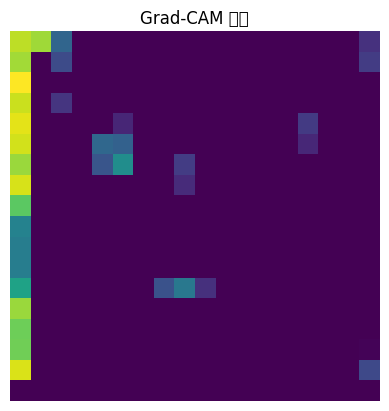

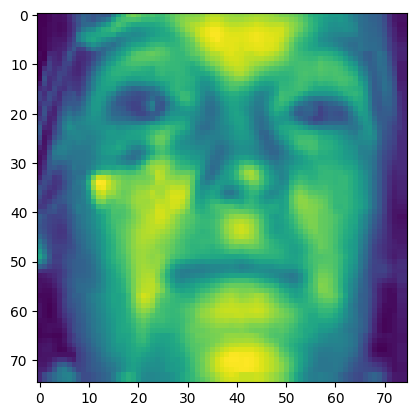

In [12]:
# Grad-CAM을 위한 코드 예시 (한글 주석 포함)
import torch
import torch.nn.functional as F

def find_last_conv_layer(model):
    """
    모델에서 마지막 Conv2d 또는 Conv3d 레이어를 찾아 반환합니다.
    """
    last_conv = None
    last_name = None
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Conv3d)):
            last_conv = module
            last_name = name
    if last_conv is None:
        raise ValueError("Conv2d/Conv3d 레이어를 찾을 수 없습니다.")
    return last_conv, last_name

def generate_gradcam(model, input_tensor, target_class=None, target_layer_name=None):
    """
    model: 학습된 모델 (CNN_LSTM)
    input_tensor: (1, 1, T, H, W) 또는 (1, T, H, W) 형태의 입력
    target_class: 관심있는 클래스 인덱스 (None이면 예측값 사용)
    target_layer_name: Grad-CAM을 적용할 레이어 이름 (None이면 마지막 Conv2d/Conv3d 자동 탐색)
    """
    model.eval()
    # hook을 위한 변수
    activations = {}
    gradients = {}

    def forward_hook(module, input, output):
        activations['value'] = output.detach()

    def backward_hook(module, grad_in, grad_out):
        gradients['value'] = grad_out[0].detach()

    # 타겟 레이어 찾기
    if target_layer_name is not None:
        # cnn2d, cnn3d 등 여러 네임스페이스 지원
        found = False
        for prefix in ['cnn2d', 'cnn3d', 'features', 'module', '']:
            try:
                if prefix:
                    named_modules = dict([*getattr(model, prefix).named_modules()])
                else:
                    named_modules = dict([*model.named_modules()])
                target_layer = named_modules[target_layer_name]
                found = True
                break
            except (AttributeError, KeyError):
                continue
        if not found:
            raise KeyError(f"Grad-CAM 타겟 레이어 '{target_layer_name}'을(를) 찾을 수 없습니다. 모델 구조를 확인하세요.")
    else:
        # 자동으로 마지막 Conv2d/Conv3d 찾기
        target_layer, target_layer_name = find_last_conv_layer(model)

    forward_handle = target_layer.register_forward_hook(forward_hook)
    backward_handle = target_layer.register_full_backward_hook(backward_hook)

    # 입력 shape 맞추기
    if input_tensor.ndim == 4:
        input_tensor = input_tensor.unsqueeze(1)
    input_tensor = input_tensor.to(next(model.parameters()).device).float()

    # 순전파
    output = model(input_tensor)
    if target_class is None:
        target_class = output.argmax(dim=1).item()
    score = output[0, target_class]

    # 역전파
    model.zero_grad()
    score.backward()

    # Grad-CAM 계산
    # activation shape: (B, C, T, H, W) 또는 (B, C, H, W) 등 다양한 경우 지원
    activation = activations['value']  # (B, C, ...)
    grads = gradients['value']         # (B, C, ...)

    # 공간 차원 자동 추출 (C, ...)
    spatial_dims = list(range(2, activation.ndim))
    pooled_grad = grads.mean(dim=spatial_dims, keepdim=True)  # (B, C, 1, 1, ...)
    weights = pooled_grad[0]  # (C, 1, 1, ...)
    act = activation[0]       # (C, ...)

    # 가중합
    gradcam = (weights * act).sum(dim=0)
    gradcam = F.relu(gradcam)
    gradcam = gradcam.cpu().numpy()
    # 0~1 정규화
    gradcam = (gradcam - gradcam.min()) / (gradcam.max() - gradcam.min() + 1e-8)

    # hook 해제
    forward_handle.remove()
    backward_handle.remove()

    # 3D일 경우(예: (T, H, W)), 가운데 프레임만 시각화
    if gradcam.ndim == 3:
        t = gradcam.shape[0] // 2
        gradcam = gradcam[t]
    elif gradcam.ndim > 2:
        # 2D가 아닐 경우 첫 번째 차원만 사용
        gradcam = gradcam[0]

    return gradcam

# 예시 사용법
test_images, test_labels, *_ = next(iter(test_dataloader))
gradcam_map = generate_gradcam(model, test_images[0:1], target_layer_name=None)  # 자동으로 마지막 Conv2d/Conv3d 사용

import matplotlib.pyplot as plt
plt.imshow(gradcam_map)
plt.title("Grad-CAM 결과")
plt.axis('off')
plt.show()

plt.imshow(test_images[0][0])
plt.show()

In [4]:
# 테스트 코드
model.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    pbar_test = tqdm(test_dataloader, desc="테스트 진행중")
    for images, labels, _ in pbar_test:
        images = images.to(device, dtype=torch.float)
        labels = labels.to(device)
        if images.ndim == 5 and images.shape[1] == 1:
            pass
        elif images.ndim == 4:
            images = images.unsqueeze(1)
        else:
            raise ValueError(f"입력 shape 오류: {images.shape}, (B, 30, 75, 75) 또는 (B, 1, 30, 75, 75) 이어야 합니다.")
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        current_test_loss = test_loss / test_total if test_total > 0 else 0
        current_test_acc = test_correct / test_total * 100 if test_total > 0 else 0
        pbar_test.set_postfix({'loss': f'{current_test_loss:.4f}', 'acc': f'{current_test_acc:.2f}%'})
    test_epoch_loss = test_loss / test_total
    test_epoch_acc = test_correct / test_total * 100
    print(f"테스트 Loss: {test_epoch_loss:.4f} Acc: {test_epoch_acc:.2f}%")

테스트 진행중: 100%|██████████| 412/412 [00:35<00:00, 11.46it/s, loss=2.0792, acc=67.84%]

테스트 Loss: 2.0792 Acc: 67.84%


In [ ]:
import random
from collections import deque

def create_random_teams_by_name(names, people_per_team):
    """
    참가자 명단과 팀당 인원 수를 받아 랜덤 팀을 생성하고, 좌미우미(중복 인원)도 반환합니다.
    """
    total_people = len(names)
    if total_people < people_per_team:
        print("팀원 수가 전체 인원보다 많을 수 없습니다.")
        return [], set()

    names = names[:]  # 원본 보호
    random.shuffle(names)

    num_teams = total_people // people_per_team
    remainder = total_people % people_per_team
    duplicated_members = set()

    # 인원이 딱 맞지 않으면 중복 인원 추가
    if remainder != 0:
        need = people_per_team - remainder
        extra_members = random.sample(names, k=need)
        duplicated_members.update(extra_members)
        names.extend(extra_members)
        total_people = len(names)
        num_teams = total_people // people_per_team

    teams = []
    index = 0
    for _ in range(num_teams):
        team = names[index:index + people_per_team]
        teams.append(team)
        index += people_per_team

    return teams, duplicated_members

def print_teams_and_score(teams, people_per_team, duplicated_members):
    """
    팀 구성과 점수, 좌미우미(중복 인원)를 출력합니다.
    """
    for i, team in enumerate(teams, 1):
        print(f"팀 {i}: {team}")
    print()
    score_min = people_per_team * 3
    score_max = people_per_team * 60
    score = random.randint(score_min, score_max)
    print(f"점수: {score}\n")
    if duplicated_members:
        print(f"좌미우미 : {', '.join(duplicated_members)}")

def make_tournament_bracket(teams):
    """
    토너먼트 대진표를 출력합니다.
    """
    print("\n[토너먼트 대진표]")
    num_teams = len(teams)
    if num_teams & (num_teams-1) != 0:
        print("※ 팀 수가 2의 제곱이 아니므로 부전승이 발생할 수 있습니다.")
    match_num = 1
    for i in range(0, num_teams, 2):
        if i+1 < num_teams:
            print(f"경기 {match_num}: {teams[i]} vs {teams[i+1]}")
        else:
            print(f"경기 {match_num}: {teams[i]} (부전승)")
        match_num += 1

def make_league_schedule(teams):
    """
    리그전 대진표를 출력합니다.
    """
    print("\n[리그전 대진표]")
    num_teams = len(teams)
    match_num = 1
    first_count = [0] * num_teams
    second_count = [0] * num_teams
    matches = []
    for i in range(num_teams):
        for j in range(i+1, num_teams):
            matches.append((i, j))

    scheduled = []
    matches = deque(matches)

    while matches:
        found = False
        for _ in range(len(matches)):
            i, j = matches[0]
            if (not scheduled or (i not in scheduled[-1] and j not in scheduled[-1])):
                scheduled.append((i, j))
                matches.popleft()
                found = True
                break
            else:
                matches.rotate(-1)
        if not found:
            scheduled.append(matches.popleft())

    for idx, (i, j) in enumerate(scheduled):
        if idx % 2 == 0:
            first, second = i, j
        else:
            first, second = j, i
        first_count[first] += 1
        second_count[second] += 1
        print(f"팀 {first+1} vs 팀 {second+1}")
        match_num += 1

def make_throwing_order(names):
    """
    던지는 순서를 랜덤으로 출력합니다.
    """
    print("\n[던지는 순서]")
    order = names[:]
    random.shuffle(order)
    for idx, name in enumerate(order, 1):
        print(f"{idx}번: {name}")

def main(names, people_per_team, game_type):
    """
    메인 실행 함수. 게임 종류에 따라 분기합니다.
    """
    if not names:
        print("참가자가 없습니다.")
        return

    if game_type == "토너먼트":
        teams, duplicated_members = create_random_teams_by_name(names, people_per_team)
        print_teams_and_score(teams, people_per_team, duplicated_members)
        make_tournament_bracket(teams)
    elif game_type == "리그":
        teams, duplicated_members = create_random_teams_by_name(names, people_per_team)
        print_teams_and_score(teams, people_per_team, duplicated_members)
        make_league_schedule(teams)
    elif game_type == "순서대로":
        make_throwing_order(names)
    else:
        print("지원하지 않는 게임 종류입니다.")

# 이름 후보
# "문지연", "이미영", "박송희", "김시진", "안병선", "정세림", "김승현", "신은빈", "이승건", "황정원", "정승민", "이학진", "석채린", "박영제", "이정곤"
if __name__ == "__main__":
    names = ["문지연", "이미영", "김시진", "안병선", "박영제", "이승건", "이학진"]
    people_per_team = 2  # 팀당 인원 수 지정
    game_type = "토너먼트"
    main(names, people_per_team, game_type)

팀 1: ['이미영', '김시진']
팀 2: ['문지연', '이학진']
팀 3: ['박영제', '이승건']
팀 4: ['안병선', '안병선']

점수: 105

좌미우미 : 안병선

[토너먼트 대진표]
경기 1: ['이미영', '김시진'] vs ['문지연', '이학진']
경기 2: ['박영제', '이승건'] vs ['안병선', '안병선']


In [ ]:
# 테스트 코드 추가
mobilenet_v3.eval()
test_loss = 0.0
test_correct = 0
test_total = 0
with torch.no_grad():
    pbar_test = tqdm(test_dataloader, desc="테스트 진행중")
    for images, labels, _ in pbar_test:
        images = images.to(device)
        labels = labels.to(device)
        outputs = mobilenet_v3(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        test_total += labels.size(0)
        test_correct += predicted.eq(labels).sum().item()
        current_test_loss = test_loss / test_total if test_total > 0 else 0
        current_test_acc = test_correct / test_total * 100 if test_total > 0 else 0
        pbar_test.set_postfix({'loss': f'{current_test_loss:.4f}', 'acc': f'{current_test_acc:.2f}%'})

테스트 진행중:  52%|█████▏    | 1077/2060 [04:24<04:01,  4.07it/s, loss=1.9981, acc=31.64%]


KeyboardInterrupt: 

## Signal

In [1]:
from datatset import DROZY_EYELANDMARK_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="./DROZY/gaeMuRan/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="./DROZY/gaeMuRan/split_eye_landmark/test")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

import torch
import torch.nn as nn
import torch.optim as optim
from importlib import import_module

ResNet1D = getattr(import_module("1dresnet"), "ResNet1D")
def check_batch(rrsp_bpm, kss_label, sample_path):
    # sample_path는 rrsp_bpm, kss_label과 순서가 대응되는 path의 리스트임
    if not torch.isfinite(rrsp_bpm).all():
        idxs = (~torch.isfinite(rrsp_bpm)).any(dim=1) if rrsp_bpm.dim() > 1 else ~torch.isfinite(rrsp_bpm)
        for i in torch.where(idxs)[0]:
            print(f"[!] rrsp_bpm 이상치 있음 - sample_path: {sample_path[i]}")
    if not torch.isfinite(kss_label).all():
        idxs = ~torch.isfinite(kss_label)
        for i in torch.where(idxs)[0]:
            print(f"[!] label 이상치 있음 - sample_path: {sample_path[i]}")
# rrsp_bpm의 shape: (batch, 96, 600)z
# 96: feature 개수, 600: 프레임 개수
# Conv1d의 in_channels=feature 개수(96), seq_len=600
class RRSP_1DCNN(nn.Module):
    def __init__(self, num_classes=3, input_size=150):
        super(RRSP_1DCNN, self).__init__()
        # 입력: (batch, 96, 600)
        # Conv1d 입력: (batch, in_channels=96, seq_len=600)
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=128, kernel_size=7, padding=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.conv2 = nn.Conv1d(in_channels=128, out_channels=256, kernel_size=5, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.conv3 = nn.Conv1d(in_channels=256, out_channels=128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm1d(128)
        self.relu3 = nn.ReLU()
        self.global_pool = nn.AdaptiveAvgPool1d(1)  # (batch, channel, 1)
        self.fc = nn.Linear(128, num_classes)

    def forward(self, x):
        # x: (batch, 96, 600)
        # 만약 x가 (batch, 96, 600)이 아니고 (batch, 600, 96)이면 permute 필요
        if x.shape[1] != 96:
            # (batch, 600, 96) -> (batch, 96, 600)
            x = x.permute(0, 2, 1)
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.global_pool(x)  # (batch, channel, 1)
        x = x.squeeze(-1)        # (batch, channel)
        x = self.fc(x)           # (batch, num_classes)
        return x

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RRSP_1DCNN(num_classes=3, input_size=150).to(device)
model = model.float()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    loss_list = []
    pbar = tqdm(train_dataloader)
    pbar.set_description(f"Epoch [{epoch+1}/{num_epochs}]")
    for rrsp_bpm, kss_label, sample_path in pbar:
        # nan이 포함된 배치는 건너뜀

        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        
        optimizer.zero_grad()
        outputs = model(rrsp_bpm)
        loss = criterion(outputs, kss_label)
        check_batch(rrsp_bpm, kss_label, sample_path)

        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        avg_loss = sum(loss_list) / len(loss_list)
        pbar.set_postfix(loss=avg_loss)

    # 검증
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(test_dataloader)
        pbar.set_description("테스트 진행중")
        for rrsp_bpm, kss_label,sample_path in pbar:
            rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
            kss_label = kss_label.to(device)
            outputs = model(rrsp_bpm)
            check_batch(rrsp_bpm, kss_label, sample_path)

            _, predicted = torch.max(outputs, 1)
            total += kss_label.size(0)
            correct += (predicted == kss_label).sum().item()
            acc = correct / total * 100
            pbar.set_postfix(acc=f"{acc:.2f}%")
    print(f"테스트 정확도: {acc:.2f}%")


테스트 진행중: 100%|██████████| 83/83 [01:14<00:00,  1.11it/s, acc=34.91%]


테스트 정확도: 34.91%


Epoch [2/10]:  48%|████▊     | 119/247 [01:03<01:08,  1.86it/s, loss=1.06]


KeyboardInterrupt: 

In [ ]:
from torch.utils.data import DataLoader
from tqdm import trange
from datatset import DROZY_EYELANDMARK_Dataset
train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/test")

bad_indices = []
for i in trange(len(train_dataset)):
    try:
        rrsp_bpm, kss_label = train_dataset[i]
        if rrsp_bpm.numel() == 0 or kss_label.numel() == 0:
            print(f"문제 있는 샘플 발견: {i}")
            bad_indices.append((i, rrsp_bpm.shape, kss_label.shape))
    except Exception as e:
        bad_indices.append((i, "Exception", str(e)))

print(f"총 {len(bad_indices)}개의 문제 있는 샘플 발견:")
for idx, rrsp_shape, kss_shape in bad_indices:
    print(f"  - Index {idx}: rrsp_bpm shape = {rrsp_shape}, kss_label shape = {kss_shape}")


100%|██████████| 13754/13754 [12:27<00:00, 18.40it/s]

총 0개의 문제 있는 샘플 발견:


In [ ]:

model.eval()
correct = 0
total = 0
with torch.no_grad():
    pbar = tqdm(train_dataloader)
    pbar.set_description("테스트 진행중")
    for rrsp_bpm, kss_label in pbar:
        # 텐서에 nan이 포함되어 있으면 해당 배치는 건너뜀
        # if torch.isnan(rrsp_bpm).any() or torch.isnan(kss_label).any():
        #     continue
        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        # outputs에 nan이 포함되어 있으면 건너뜀
        # if torch.isnan(outputs).any():
        #     continue
        _, predicted = torch.max(outputs, 1)
        total += kss_label.size(0)
        correct += (predicted == kss_label).sum().item()
        acc = correct / total * 100
        pbar.set_postfix(acc=f"{acc:.2f}%")

테스트 진행중:   4%|▎         | 8/216 [00:23<10:11,  2.94s/it, acc=30.66%]


KeyboardInterrupt: 

In [ ]:
acc

29.83133061404476

In [ ]:
from datatset import DROZY_EYELANDMARK_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/train")
test_dataset = DROZY_EYELANDMARK_Dataset(split_dir="G:/DROZY_signals/split_eye_landmark/test")

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=False, pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

for data in tqdm(train_dataloader):
    pass  # 모든 학습 데이터 순회


  3%|▎         | 6/215 [00:28<16:41,  4.79s/it]


KeyboardInterrupt: 

In [ ]:
test_data

(tensor([ 8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,  8.,
          8.,  8.,  8.,  8.,  8.,  8.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,  9.,
          9.,  9.,  9.,  9.,  9.,  9., 10., 10., 10., 10., 10., 10., 10., 10.,
         10., 10., 10., 10., 10., 11., 11., 11., 11., 11., 12., 12., 12., 13.,
         13., 13., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14., 14.,
         14., 15., 15., 15., 15., 15., 15., 15., 16., 16., 16., 16., 16., 16.,
         16., 16., 17., 17., 17., 17., 17., 17., 17., 17., 18., 18., 18., 18.,
         18., 18., 18., 19., 19., 19., 19., 19., 19., 19., 19., 19., 20., 20.,
         20., 20., 20., 20., 20., 20., 20., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21., 21.,
         21., 21., 21., 21., 21., 21., 21., 21., 21.

In [ ]:
from datatset import DROZY_RRSP_Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm

train_dataset = DROZY_RRSP_Dataset(split_dir="./split_samples/train")
test_dataset = DROZY_RRSP_Dataset(split_dir="./split_samples/test")

for test_data in train_dataset:
    pass

sample_path 에서 에러 발생: ./split_samples/train\1-2\sample_00165.csv


KeyError: 'rrsp_bpm_final'

테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.80it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.00it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 16.12it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 16.08it/s, acc=45.45%]


테스트 정확도: 45.45%


테스트 진행중: 100%|██████████| 99/99 [00:06<00:00, 15.51it/s, acc=45.45%]

테스트 정확도: 45.45%


In [ ]:
total, correct

(6335, 2879)

Epoch [1/5]:   0%|          | 0/222 [00:00<?, ?it/s]


RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 혼동행렬 계산 및 시각화
all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for rrsp_bpm, kss_label in test_dataloader:
        rrsp_bpm = rrsp_bpm.to(device)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(kss_label.cpu().numpy())



NameError: name 'plt' is not defined

테스트 진행중: 100%|██████████| 139/139 [04:23<00:00,  1.89s/it, acc=48.52%]


테스트 정확도: 48.52%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=56.76%]


테스트 정확도: 56.76%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=33.06%]


테스트 정확도: 33.06%


테스트 진행중: 100%|██████████| 139/139 [04:19<00:00,  1.87s/it, acc=51.09%]


테스트 정확도: 51.09%


테스트 진행중: 100%|██████████| 139/139 [04:20<00:00,  1.87s/it, acc=61.50%]


테스트 정확도: 61.50%


테스트 진행중: 100%|██████████| 139/139 [04:20<00:00,  1.87s/it, acc=52.91%]


테스트 정확도: 52.91%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=45.10%]


테스트 정확도: 45.10%


테스트 진행중: 100%|██████████| 139/139 [04:17<00:00,  1.85s/it, acc=56.67%]


테스트 정확도: 56.67%


테스트 진행중: 100%|██████████| 139/139 [04:18<00:00,  1.86s/it, acc=60.40%]


테스트 정확도: 60.40%


테스트 진행중: 100%|██████████| 139/139 [04:19<00:00,  1.87s/it, acc=61.50%]

테스트 정확도: 61.50%


c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49892 (\N{HANGUL SYLLABLE SIL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51228 (\N{HANGUL SYLLABLE JE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 44050 (\N{HANGUL SYLLABLE GABS}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 53580 (\N{HANGUL SYLLABLE TE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\Genius Park\AppData\Local\anaconda3\envs\cuda12_1\lib\site-packages\IPython\

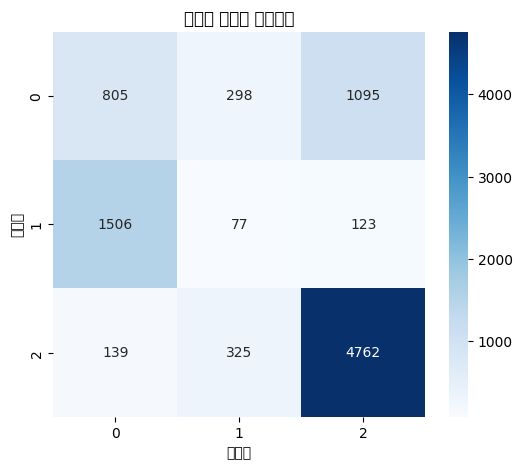

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 테스트 데이터 전체 예측값과 실제값을 저장할 리스트
all_labels = []
all_preds = []

model.eval()
with torch.no_grad():
    for rrsp_bpm, kss_label in test_dataloader:
        if torch.isnan(rrsp_bpm).any() or torch.isnan(kss_label).any():
            continue
        rrsp_bpm = rrsp_bpm.to(device, dtype=torch.float32)
        kss_label = kss_label.to(device)
        outputs = model(rrsp_bpm)
        if torch.isnan(outputs).any():
            continue
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(kss_label.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("예측값")
plt.ylabel("실제값")
plt.title("테스트 데이터 혼동행렬")
plt.show()


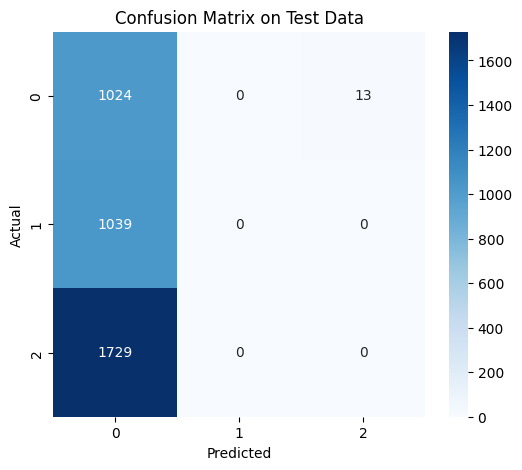

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

In [ ]:


model = ResNet1D(
    in_channels=96,
    base_filters=16,
    kernel_size=7,
    stride=1,
    groups=1,
    n_block=5,
    n_classes=3,
    downsample_gap=2,
    increasefilter_gap=4,
    use_bn=True,
    use_do=True,
    verbose=False
)

In [ ]:
import matplotlib.pyplot as plt

cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0,1,2], yticklabels=[0,1,2])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix on Test Data")
plt.show()

NameError: name 'confusion_matrix' is not defined

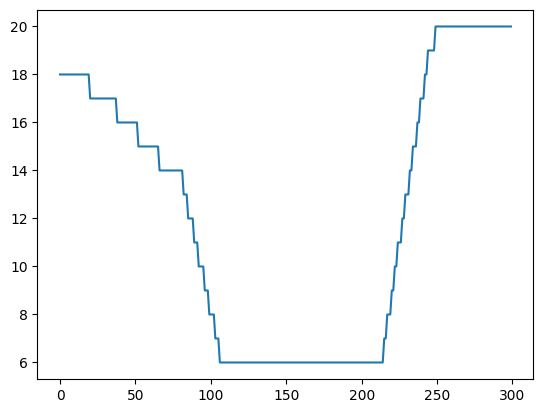

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

file_path = "./split_samples/train/1-1/sample_00630.csv"
df = pd.read_csv(file_path)

# rrsp_bpm_final 컬럼만 추출하여 리스트로 변환
rrsp_bpm_list = df['rrsp_bpm_final'].tolist()

plt.plot(rrsp_bpm_list)
plt.show()

In [ ]:
kss_path = "./DROZY/KSS.txt"
kss_dict = {}
key_list = []
for i in range(1, 15):
    for j in range(1, 4):
        key_list.append(f"{i}-{j}")

with open(kss_path, 'r') as f:
    kss_values = []
    for line in f:
        kss_values.extend(line.strip().split())

# KSS 값을 1~3은 0, 4~6은 1, 7~9는 3으로 치환
def map_kss_value(val):
    v = int(val)
    if 1 <= v <= 3:
        return 0
    elif 4 <= v <= 6:
        return 1
    elif 7 <= v <= 9:
        return 3
    else:
        return v  # 혹시 모를 예외 처리

for idx, key in enumerate(key_list):
    kss_dict[key] = map_kss_value(kss_values[idx])

In [ ]:
kss_dict

{'1-1': 0,
 '1-2': 1,
 '1-3': 3,
 '2-1': 0,
 '2-2': 3,
 '2-3': 1,
 '3-1': 0,
 '3-2': 0,
 '3-3': 1,
 '4-1': 1,
 '4-2': 3,
 '4-3': 3,
 '5-1': 0,
 '5-2': 3,
 '5-3': 3,
 '6-1': 0,
 '6-2': 0,
 '6-3': 3,
 '7-1': 0,
 '7-2': 1,
 '7-3': 3,
 '8-1': 0,
 '8-2': 1,
 '8-3': 3,
 '9-1': 0,
 '9-2': 1,
 '9-3': 3,
 '10-1': 0,
 '10-2': 1,
 '10-3': 3,
 '11-1': 1,
 '11-2': 3,
 '11-3': 3,
 '12-1': 0,
 '12-2': 1,
 '12-3': 1,
 '13-1': 1,
 '13-2': 0,
 '13-3': 3,
 '14-1': 1,
 '14-2': 3,
 '14-3': 3}

### 신호 데이터 확인

In [ ]:
# import pandas as pd
# # import numpy as np
# # import cv2

# # # CSV 파일 경로
# # df_path = "G:/DROZY_signals/split_eye_landmark/train/5-2/sample_00300.csv"
# # df = pd.read_csv(df_path)

# # # 전체 프레임 수
# # num_frames = len(df)

# # # 랜드마크 키 추출
# # landmark_keys = sorted(set(col[:-2] for col in df.columns if col.endswith("_x")))

# # # 프레임 사이즈 키우기
# # canvas_size = (1024, 1024)

# # frame_index = 0
# # while True:
# #     # 흰색 배경 캔버스
# #     canvas = np.ones((canvas_size[1], canvas_size[0], 3), dtype=np.uint8) * 255

# #     frame = df.iloc[frame_index]
# #     for i, key in enumerate(landmark_keys):
# #         x = int(frame[f"{key}_x"] * canvas_size[0])
# #         y = int(frame[f"{key}_y"] * canvas_size[1])
# #         cv2.circle(canvas, (x, y), 6, (255, 0, 0), -1)  # 점 크게
# #         cv2.putText(canvas, str(i), (x + 4, y - 4), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 0), 2)

# #     cv2.putText(canvas, f"Frame {frame_index}", (30, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
# #     cv2.imshow("Landmark Viewer", canvas)

# #     key = cv2.waitKey(0) & 0xFF
# #     if key == ord('d'):
# #         frame_index += 1
# #         if frame_index >= num_frames:
# #             print("마지막 프레임입니다.")
# #             break
# #     elif key == ord('q'):
# #         print("종료합니다.")
# #         break

# # cv2.destroyAllWindows()


In [ ]:
import pandas as pd
import glob
import concurrent.futures
from tqdm import tqdm

csv_paths = glob.glob("G:/DROZY_signals/split_eye_landmark/test/*/*.csv")
nan_file_list = []

def check_nan(path):
    try:
        df = pd.read_csv(path)
        if df.isnull().values.any():
            return path
    except Exception as e:
        print(f"파일 읽기 오류: {path}, 에러: {e}")
    return None

with concurrent.futures.ThreadPoolExecutor() as executor:
    results = list(tqdm(executor.map(check_nan, csv_paths), total=len(csv_paths), desc="NaN 검사 중"))

nan_file_list = [r for r in results if r is not None]

print("NaN 값이 있는 파일 목록:")
for file in nan_file_list:
    print(file)


NaN 검사 중: 100%|██████████| 9167/9167 [01:45<00:00, 86.79it/s] 

NaN 값이 있는 파일 목록:


In [ ]:
nan_file_list

[]

In [ ]:
!pip install send2trash

In [ ]:
from send2trash import send2trash
import os

trash_dir = "G:/DROZY_signals/split_eye_landmark/trashbin"
os.makedirs(trash_dir, exist_ok=True)

for file_path in nan_file_list:
    try:
        file_name = os.path.basename(file_path)
        dest_path = os.path.join(trash_dir, file_name)
        os.rename(file_path, dest_path)
        print(f"{file_path} → {dest_path}로 이동 완료")
    except Exception as e:
        print(f"{file_path} 이동 실패: {e}")


In [21]:
import numpy as np
from pyts.image import MarkovTransitionField
import mediapipe as mp
from sklearn.decomposition import PCA
import cv2
import glob
import os
from tqdm import tqdm  # tqdm 추가

def extract_landmarks_from_frame(frame, face_mesh, all_indices):
    """
    Mediapipe를 이용해 frame에서 all_indices에 해당하는 landmark를 추출
    """
    import cv2
    image_rgb = cv2.cvtColor(frame[:, :, :3], cv2.COLOR_BGR2RGB)
    results = face_mesh.process(image_rgb)
    if results.multi_face_landmarks:
        face = results.multi_face_landmarks[0]
        coords = [[face.landmark[i].x, face.landmark[i].y, face.landmark[i].z] for i in all_indices]
        return coords
    else:
        return None

def interpolate_landmarks_ffill(landmarks_list, npy_path, face_mesh, all_indices):
    total_frames = len(landmarks_list)
    interpolated = [None] * total_frames
    # Step 1: Convert list to array with NaNs
    for i, landmarks in enumerate(landmarks_list):
        if landmarks is not None:
            interpolated[i] = landmarks
        else:
            interpolated[i] = None
        
        # [NEW] If first frame is None and search_prev is enabled
        if interpolated[0] is None:
            print(f"[INFO] First frame is None, searching previous files for {npy_path}")
            current_idx = int(os.path.basename(npy_path).split('.')[0])  # e.g., 4200
            step = 150  # overlap step size
            base_dir = os.path.dirname(npy_path)
            

            for prev_start in range(current_idx - step, -1, -step):  # 4050 → 3900 → 3750 ...
                prev_path = os.path.join(base_dir, f"{prev_start}.npy")
                if os.path.exists(prev_path):
                    try:

                        prev_data = np.load(prev_path, allow_pickle=True)
                        prev_target_idx = current_idx - 1 - prev_start  # e.g., 4199 - 4050 = 149

                        # [NEW] 역순으로 landmark가 있는 가장 최근 프레임 탐색
                        for idx in range(prev_target_idx, -1, -1):
                            frame = prev_data[idx]
                            if frame is not None:
                                landmarks_prev = extract_landmarks_from_frame(frame, face_mesh, all_indices)
                                if landmarks_prev is not None:
                                    interpolated[0] = np.array(landmarks_prev)
                                    break
                                
                        if interpolated[0] is not None:
                            break  # break for-loop over files
                    except Exception as e:
                        print(f"[WARN] Failed to load previous file {prev_path}: {e}")

    # Step 2: Forward fill
    last_valid = None
    for i in range(total_frames):
        if interpolated[i] is not None:
            last_valid = interpolated[i]
        else:
            if last_valid is not None:
                interpolated[i] = np.array(last_valid)

    interpolated_array = np.stack(interpolated)  # shape: (frames, landmarks, 3)
    return interpolated_array

face_landmarks_indices = {
    "right_eyebrow": [46, 53, 52, 65, 55, 107, 66, 105, 63, 70],
    "left_eyebrow": [276, 283, 282, 295, 285, 336, 296, 334, 293, 300],
    "right_eye": [33, 133, 160, 158, 144, 153, 145, 362, 385, 387, 263, 373, 380, 374],
    "left_eye": [263, 362, 385, 387, 373, 380, 374, 33, 133, 160, 158, 144, 153, 145],
    "nose": [6, 197, 195, 5, 4, 45, 220, 115, 48],
    "nose_tip": [1],
    "nostrils": [49, 279, 309, 458],
    "outer_lips": [61, 146, 91, 181, 84, 17, 314, 405, 321, 375, 291, 308],
    "inner_lips": [78, 95, 88, 178, 87, 14, 317, 402, 318, 324, 308]
}
all_indices = sorted(list(set([idx for group in face_landmarks_indices.values() for idx in group])))

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

face_landmarks = []

## 경로 설정해야합니다
avi_path_list = glob.glob("./DROZY/gaeMuRan/interpolated_videos/*.mp4")
# base_path = 

for npy_path in tqdm(avi_path_list, desc="전체 파일 진행 상황"):  # tqdm으로 전체 파일 진행률 표시
    print('npy_path',npy_path)
    # npy_path는 avi 파일 경로이므로, np.load로 불러올 수 없습니다.
    # avi 파일을 프레임 단위로 읽어서 face_npy에 저장해야 합니다.
    cap = cv2.VideoCapture(npy_path)
    face_npy = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        face_npy.append(frame)
    cap.release()
    face_npy = np.array(face_npy)
    face_landmarks = []
    for frame in tqdm(face_npy, desc=f"{os.path.basename(npy_path)} 프레임 처리", leave=False):  # tqdm으로 프레임 진행률 표시
        image_rgb = cv2.cvtColor(frame[:, :, :3], cv2.COLOR_BGR2RGB)
        results = face_mesh.process(image_rgb)
        if results.multi_face_landmarks:
            face = results.multi_face_landmarks[0]
            coords = [[face.landmark[i].x, face.landmark[i].y, face.landmark[i].z] for i in all_indices]
            face_landmarks.append(coords)
        else:
            face_landmarks.append(None)

    face_landmarks = interpolate_landmarks_ffill(face_landmarks, npy_path, face_mesh, all_indices)
    face_landmarks = np.array(face_landmarks)

    # 1분 window, 1초 stride로 split
    fps = 30  # FPS를 실제 영상에 맞게 지정하세요
    window_size = 60 * fps  # 1분 window
    stride = 1 * fps        # 1초 stride

    total_frames = face_landmarks.shape[0]
    window_idx = 0

    for start in range(0, total_frames - window_size + 1, stride):
        end = start + window_size
        window_landmarks = face_landmarks[start:end]

        # PCA 적용
        pca = PCA(n_components=1)
        x_landmarks_pca = pca.fit_transform(window_landmarks[:, :, 0].T).T
        y_landmarks_pca = pca.fit_transform(window_landmarks[:, :, 1].T).T
        z_landmarks_pca = pca.fit_transform(window_landmarks[:, :, 2].T).T

        window_landmarks_pca = np.stack((x_landmarks_pca, y_landmarks_pca, z_landmarks_pca), axis=-1)

        mtf = MarkovTransitionField(image_size=70)
        mtf_images = []

        for i in tqdm(range(window_landmarks_pca.shape[-1]), desc=f"MTF 변환 (window {window_idx})", leave=False):
            mtf_image = mtf.fit_transform(window_landmarks_pca[:, :, i])
            mtf_images.append(mtf_image)

        mtf_images = np.stack(mtf_images, axis=-1)

        # 저장 경로 생성 및 저장
        save_path = npy_path.replace('interpolated_videos', 'interpolated_videos_mtf')
        save_dir = os.path.dirname(save_path)
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        # 파일명에 window index 추가
        base, ext = os.path.splitext(save_path)
        save_path_window = f"{base}_window{window_idx}{ext}"

        np.save(save_path_window, mtf_images)
        window_idx += 1


전체 파일 진행 상황:   0%|          | 0/36 [00:00<?, ?it/s]

npy_path ./DROZY/gaeMuRan/interpolated_videos\1-1_interp_30fps.mp4


전체 파일 진행 상황:   3%|▎         | 1/36 [01:38<57:14, 98.14s/it]

npy_path ./DROZY/gaeMuRan/interpolated_videos\1-2_interp_30fps.mp4


전체 파일 진행 상황:   3%|▎         | 1/36 [02:37<1:31:48, 157.38s/it]

[INFO] First frame is None, searching previous files for ./DROZY/gaeMuRan/interpolated_videos\1-2_interp_30fps.mp4


ValueError: invalid literal for int() with base 10: '1-2_interp_30fps'

In [19]:
# None 값이 있는지 탐색

import numpy as np

print("None 값 개수:", np.sum([x is None for x in face_landmarks]))
print("None 값 인덱스:", [i for i, x in enumerate(face_landmarks) if x is None])

None 값 개수: 383
None 값 인덱스: [58, 59, 60, 62, 77, 79, 81, 84, 85, 106, 108, 109, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 1914, 1938, 1939, 1940, 1941, 1942, 1945, 1955, 1956, 1957, 1981, 4377, 4379, 4380, 4381, 4382, 4383, 4386, 8481, 8482, 8483, 8484, 8485, 8486, 8619, 8620, 8622, 8623, 8624, 8635, 8639, 8640, 8641, 8642, 8643, 8644, 8645, 8646, 8647, 8648, 8649, 8650, 8651, 8652, 8653, 8654, 8655, 9517, 9520, 9521, 9522, 9523, 9524, 9525, 9526, 9528, 9529, 9531, 9535, 9536, 9537, 9538, 9539, 9540, 9550, 9551, 9552, 9553, 9554, 9555, 9574, 9576, 9577, 9578, 9579, 9580, 9581, 9582, 9583, 9584, 9585, 9586, 9587, 9588, 9589, 9590, 9591, 9599, 9607, 9608, 9609, 9610, 9611, 9612, 9613, 9614, 9615, 9616, 9617, 9618, 9619, 9620, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9845, 9846, 10273, 10274, 10326, 10327, 10328, 10329, 10330, 10338, 10340, 10341, 10344, 10345, 10346, 10347, 10348, 10349, 10350, 10351, 10352, 10353, 10354, 10355, 10356, 1035

In [17]:
len(face_landmarks)

17999